In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('lstm_garch.csv',index_col='Date')
df

,Open,High,Low,Close,Adj Close,return,log_return,realized volatility,alpha[1],beta[1]
Date,,,,,,,,,,
1928-03-05,17.570000,17.570000,17.570000,17.570000,17.570000,1.560696,2.234219,0.702718,1.190769e-16,1.000000
1928-03-06,17.670000,17.670000,17.670000,17.670000,17.670000,0.569154,0.818788,0.710786,4.727986e-15,0.079529
1928-03-07,17.580000,17.580000,17.580000,17.580000,17.580000,-0.509339,-0.736698,0.709591,0.000000e+00,0.516325
1928-03-08,17.639999,17.639999,17.639999,17.639999,17.639999,0.341294,0.491545,0.651001,0.000000e+00,0.912505
1928-03-09,17.930000,17.930000,17.930000,17.930000,17.930000,1.643996,2.352500,0.732310,6.237012e-10,1.000000
...,...,...,...,...,...,...,...,...,...,...
2022-03-28,4541.089844,4575.649902,4517.689941,4575.520020,4575.520020,0.714496,1.027134,1.482212,0.000000e+00,0.971109
2022-03-29,4602.859863,4637.299805,4589.660156,4631.600098,4631.600098,1.225655,1.757497,1.434337,1.019311e-13,0.971074
2022-03-30,4624.200195,4627.770020,4581.319824,4602.450195,4602.450195,-0.629370,-0.910858,1.443096,5.266536e-18,0.962702


In [4]:
# x_dim: the dimension of the input X
# time_steps: predict of n days
# if x_dim = 22, time steps = 1, it means we use X1 = [p1,p2,...,p22] to predict p23(y1)

def create_dataset(data, x_dim, time_steps):
    dataX, dataY = [], []
    for i in range(len(data) - x_dim - time_steps):
        dataX.append(data[i:(i + x_dim), 0])
        dataY.append(data[i + x_dim + time_steps, 0])
    return np.array(dataX), np.array(dataY).reshape(-1,1)

In [5]:
vol=np.array(df['realized volatility']).reshape(-1,1)
alpha = np.array(df['alpha[1]']).reshape(-1,1)
beta = np.array(df['beta[1]']).reshape(-1,1)

scaler_vol = MinMaxScaler(feature_range=(0,1))
scaler_alpha = MinMaxScaler(feature_range=(0,1))
scaler_beta = MinMaxScaler(feature_range=(0,1))

vol=scaler_vol.fit_transform(vol)
alpha=scaler_alpha.fit_transform(alpha)
beta=scaler_beta.fit_transform(beta)

In [6]:
x_dim = 22
time_steps = 1
x_vol,y = create_dataset(vol,x_dim,time_steps)
x_alpha = create_dataset(alpha,x_dim,time_steps)[0]
x_beta = create_dataset(beta,x_dim,time_steps)[0]

In [7]:
data = np.hstack((x_vol,x_alpha,x_beta,y))

In [8]:
ratio = 0.8
Traindata = data[0:round(len(data)*ratio)]
Testdata = data[round(len(data)*ratio):]
Traindata.shape, Testdata.shape

((18889, 67), (4722, 67))

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(Traindata, train_size=0.9)
X_train, y_train = train[:,:-1], train[:,-1]
X_test, y_test = test[:,:-1], test[:,-1]
print('Data size: {} Train size: {} Test size: {}'.format(Traindata.shape[0], X_train.shape[0], X_test.shape[0]))

Data size: 18889 Train size: 17000 Test size: 1889


In [10]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_train.shape[1],1))
print('------------------------------------------------------')
print('X_train shape: {}'.format(X_train.shape))
print('------------------------------------------------------')
print('X_test shape: {}'.format(X_test.shape))

------------------------------------------------------
X_train shape: (17000, 66, 1)
------------------------------------------------------
X_test shape: (1889, 66, 1)


In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [14]:
model = Sequential()
model.add(LSTM(32, input_shape=(x_dim*3, 1), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae', 'mape','msle'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, validation_split=2/9)
score = model.evaluate(X_train, y_train, batch_size=64, verbose=1)

Epoch 1/100
207/207 [==============================] - 3s 11ms/step - loss: 0.0123 - mae: 0.0731 - mape: 82.3256 - msle: 0.0078 - val_loss: 0.0118 - val_mae: 0.0691 - val_mape: 31003.7520 - val_msle: 0.0075
Epoch 2/100
207/207 [==============================] - 2s 10ms/step - loss: 0.0112 - mae: 0.0696 - mape: 79.7331 - msle: 0.0071 - val_loss: 0.0060 - val_mae: 0.0510 - val_mape: 28876.0430 - val_msle: 0.0037
Epoch 3/100
207/207 [==============================] - 2s 10ms/step - loss: 0.0044 - mae: 0.0444 - mape: 50.7959 - msle: 0.0028 - val_loss: 0.0039 - val_mae: 0.0431 - val_mape: 27462.3828 - val_msle: 0.0025
Epoch 4/100
207/207 [==============================] - 2s 10ms/step - loss: 0.0038 - mae: 0.0408 - mape: 45.4559 - msle: 0.0024 - val_loss: 0.0035 - val_mae: 0.0414 - val_mape: 25130.6387 - val_msle: 0.0023
Epoch 5/100
207/207 [==============================] - 2s 10ms/step - loss: 0.0035 - mae: 0.0393 - mape: 42.7667 - msle: 0.0022 - val_loss: 0.0033 - val_mae: 0.0400 - val_m

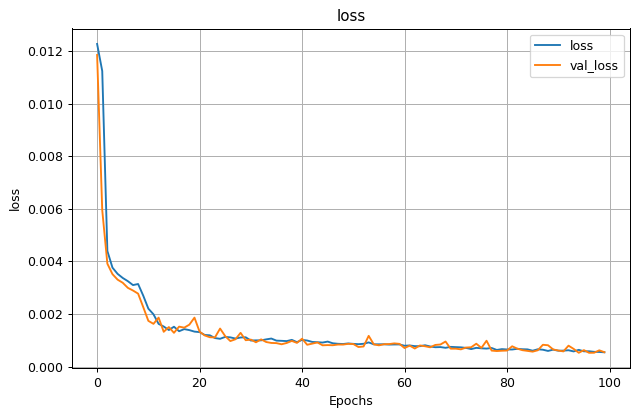

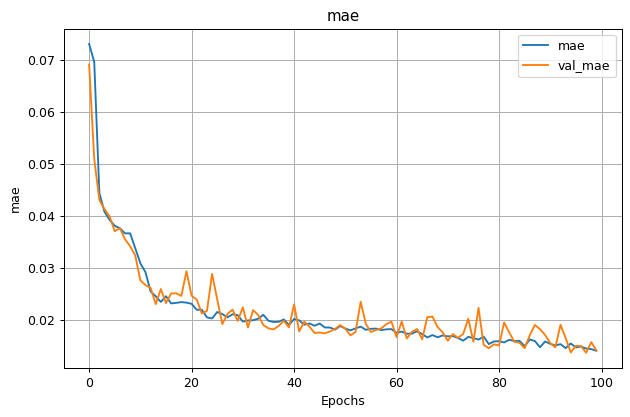

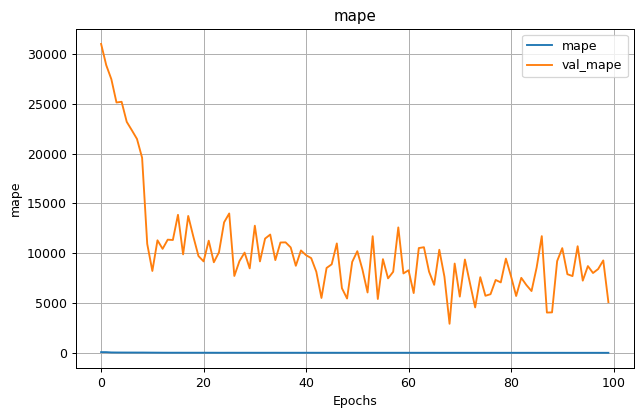

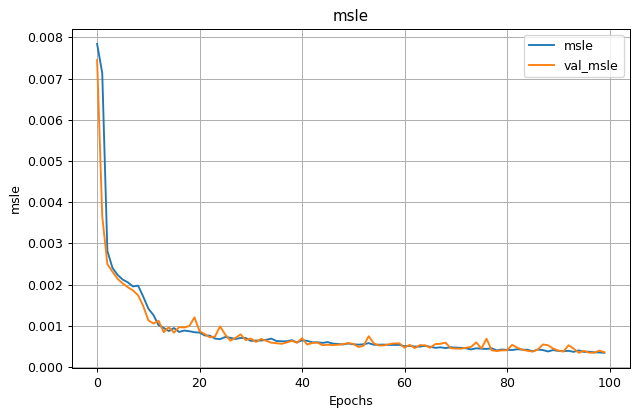

In [16]:
def visualize_loss(history, evaluation):
    train = history.history[evaluation]
    val = history.history['val_'+evaluation]
    epochs = range(len(train))
    plt.figure(figsize=(8,5),dpi=90)
    plt.plot(epochs, train, label=evaluation)
    plt.plot(epochs, val, label='val_'+evaluation)
    plt.title(evaluation)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel(evaluation)
    plt.legend()
    plt.show()

for eva in ['loss','mae', 'mape','msle']:
    visualize_loss(history, eva)

In [17]:
Test_X = Testdata[:,:-1]
Test_y = Testdata[:,-1]
Test_y_pre = model.predict(Test_X)
Test_y_pre = scaler_vol.inverse_transform(Test_y_pre)
Test_y = scaler_vol.inverse_transform(Test_y.reshape(-1,1))

In [21]:
from sklearn import metrics
mse = metrics.mean_squared_error(Test_y, Test_y_pre)
mae = metrics.mean_absolute_error(Test_y, Test_y_pre)
r2 = metrics.r2_score(Test_y, Test_y_pre)
print('r2: {:.4f}%'.format(r2*100))
print('mean squared error: {:.4f}%'.format(mse*100))
print('mean absolute error: {:.4f}%'.format(mae*100))

r2: 95.2143%
mean squared error: 2.3961%
mean absolute error: 9.0086%
